## 6.3.1 Temperature Forecasting problem

In [1]:
import os

data_dir = './jena_climate'

fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))


['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [2]:
# covert to numpy array
import numpy as np

float_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

print(float_data.shape)

(420551, 14)


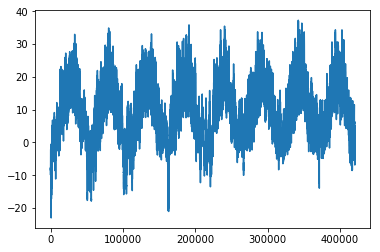

In [3]:
# now plot the temperature
import matplotlib.pyplot as plt

temp = float_data[:,1]
plt.plot(range(len(temp)),temp)
plt.show()

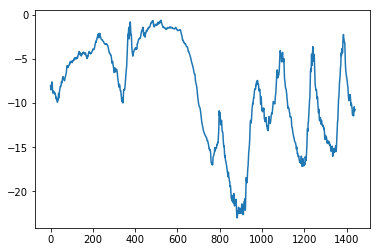

In [4]:
plt.plot(range(1440), temp[:1440])
plt.show()

In [5]:
# normalise the data
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [6]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    
    if max_index is None:
        max_index = len(data - delay - 1)
    i = max_index + lookback
    
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows), lookback//step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [7]:
# 10 min increments so observations go back 5 days
lookback = 720
# observations sampled at one data point per hour
step = 6
# targets will be 24 hours in the future
delay = 144
batch_size = 64

train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, step=step, batch_size=batch_size)
val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, step=step, batch_size=batch_size)
test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, step=step, batch_size=batch_size)

# how many steps to draw from val_gen in order to see the entire validation set
val_steps = (300000 - 200001 - lookback)
print("val_steps: ",val_steps)
# how many steps to draw from test_gen in order to set the entire test set
test_steps = (len(float_data) - 300001 - lookback)
print("test_steps: ",test_steps)

val_steps:  99279
test_steps:  119830


In [8]:
# Naive approach
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
        if step%10000 == 0:
            print(step,"/",val_steps,": ",np.mean(batch_maes))
    print(np.mean(batch_maes))

#evaluate_naive_method()

In [9]:
celcius_mae = 0.29 * std[1]
print(celcius_mae)

2.56722473384


In [10]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1680)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                53792     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 53,825
Trainable params: 53,825
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=200, epochs=10, validation_data=val_gen, validation_steps=val_steps, verbose=1)

import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Epoch 1/10
195/200 [============================>.] - ETA: 0s - loss: 2.6027

KeyboardInterrupt: 

In [29]:
# A first recurrent baseline
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

model.summary()
history = model.fit_generator(train_gen, steps_per_epoch=200, epochs=10, validation_data=val_gen, validation_steps=val_steps/batch_size)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_10 (GRU)                 (None, 32)                4512      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
 28/200 [===>..........................] - ETA: 58s - loss: 0.4075 

KeyboardInterrupt: 

Epoch 1/40
500/500 [==============================] - 76s 153ms/step - loss: 0.3409 - val_loss: 0.2769
Epoch 2/40
500/500 [==============================] - 75s 150ms/step - loss: 0.3164 - val_loss: 0.2768
Epoch 3/40
500/500 [==============================] - 75s 151ms/step - loss: 0.3110 - val_loss: 0.2741
Epoch 4/40
500/500 [==============================] - 77s 154ms/step - loss: 0.3134 - val_loss: 0.2697
Epoch 5/40
500/500 [==============================] - 75s 151ms/step - loss: 0.3066 - val_loss: 0.2746
Epoch 6/40
500/500 [==============================] - 76s 151ms/step - loss: 0.3068 - val_loss: 0.2699
Epoch 7/40
500/500 [==============================] - 77s 154ms/step - loss: 0.3040 - val_loss: 0.2712
Epoch 8/40
500/500 [==============================] - 76s 152ms/step - loss: 0.2988 - val_loss: 0.2678
Epoch 9/40
500/500 [==============================] - 79s 157ms/step - loss: 0.2999 - val_loss: 0.2670
Epoch 10/40
500/500 [==============================] - 81s 163ms/step - l

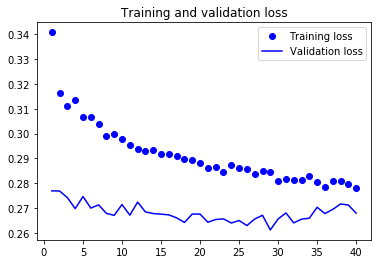

In [18]:
# Using recurrent dropout to fight overfitting
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen, validation_steps=val_steps/batch_size)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Epoch 1/40
500/500 [==============================] - 213s 426ms/step - loss: 0.3345 - val_loss: 0.2844
Epoch 2/40
500/500 [==============================] - 214s 427ms/step - loss: 0.3102 - val_loss: 0.2719
Epoch 3/40
500/500 [==============================] - 203s 405ms/step - loss: 0.3023 - val_loss: 0.2681
Epoch 4/40
500/500 [==============================] - 209s 418ms/step - loss: 0.2995 - val_loss: 0.2670
Epoch 5/40
500/500 [==============================] - 207s 415ms/step - loss: 0.2934 - val_loss: 0.2683
Epoch 6/40
500/500 [==============================] - 202s 405ms/step - loss: 0.2883 - val_loss: 0.2648
Epoch 7/40
500/500 [==============================] - 206s 411ms/step - loss: 0.2877 - val_loss: 0.2661
Epoch 8/40
500/500 [==============================] - 207s 414ms/step - loss: 0.2856 - val_loss: 0.2738
Epoch 9/40
500/500 [==============================] - 211s 422ms/step - loss: 0.2806 - val_loss: 0.2655
Epoch 10/40
500/500 [==============================] - 204s 409m

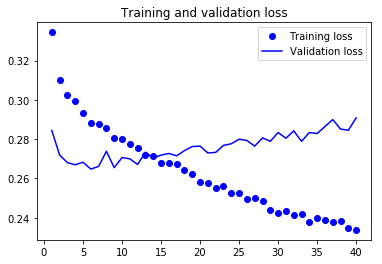

In [19]:
# Using rdropout-regularized, stacked GRU model
# Use return_sequences=True to return the full 3D tensor rather than output at the last timestep
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5, return_sequences=True, input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu', dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen, validation_steps=val_steps/batch_size)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [20]:
# Bidirectional GRU
# Requires modification of data generator to revert input sequences along time dimension

def generator_rev(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    
    if max_index is None:
        max_index = len(data - delay - 1)
    i = max_index + lookback
    
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows), lookback//step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets

        # 10 min increments so observations go back 5 days
lookback = 720
# observations sampled at one data point per hour
step = 6
# targets will be 24 hours in the future
delay = 144
batch_size = 64

train_gen_rev = generator_rev(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, step=step, batch_size=batch_size)
val_gen_rev = generator_rev(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, step=step, batch_size=batch_size)
test_gen_rev = generator_rev(float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, step=step, batch_size=batch_size)

# how many steps to draw from val_gen in order to see the entire validation set
val_steps = (300000 - 200001 - lookback)
print("val_steps: ",val_steps)
# how many steps to draw from test_gen in order to set the entire test set
test_steps = (len(float_data) - 300001 - lookback)
print("test_steps: ",test_steps)


val_steps:  99279
test_steps:  119830


Epoch 1/10
200/200 [==============================] - 42s 211ms/step - loss: 0.4629 - val_loss: 0.4636
Epoch 2/10
200/200 [==============================] - 41s 204ms/step - loss: 0.4480 - val_loss: 0.4599
Epoch 3/10
200/200 [==============================] - 40s 198ms/step - loss: 0.4404 - val_loss: 0.4485
Epoch 4/10
200/200 [==============================] - 42s 209ms/step - loss: 0.4297 - val_loss: 0.4496
Epoch 5/10
200/200 [==============================] - 40s 200ms/step - loss: 0.4049 - val_loss: 0.4357
Epoch 6/10
200/200 [==============================] - 41s 207ms/step - loss: 0.3809 - val_loss: 0.4311
Epoch 7/10
200/200 [==============================] - 41s 203ms/step - loss: 0.3616 - val_loss: 0.4124
Epoch 8/10
200/200 [==============================] - 43s 214ms/step - loss: 0.3513 - val_loss: 0.4274
Epoch 9/10
200/200 [==============================] - 45s 227ms/step - loss: 0.3361 - val_loss: 0.4015
Epoch 10/10
200/200 [==============================] - 44s 220ms/step - l

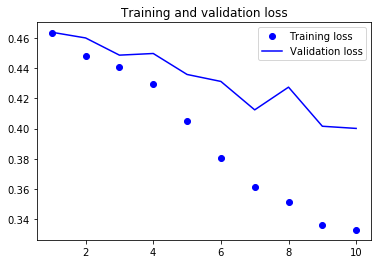

In [21]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_rev, steps_per_epoch=200, epochs=10, validation_data=val_gen_rev, validation_steps=val_steps/batch_size)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [27]:
# Training and evaluating a birdirectional LSTM
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

max_features = 10000
maxlen = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Reverse sequences
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# Pad sequences
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 292s 15ms/step - loss: 0.5932 - acc: 0.6947 - val_loss: 0.4364 - val_acc: 0.8290
Epoch 2/10
20000/20000 [==============================] - 241s 12ms/step - loss: 0.3640 - acc: 0.8529 - val_loss: 0.3176 - val_acc: 0.8738
Epoch 3/10
20000/20000 [==============================] - 330s 17ms/step - loss: 0.2765 - acc: 0.8992 - val_loss: 0.3050 - val_acc: 0.8832
Epoch 4/10
20000/20000 [==============================] - 370s 18ms/step - loss: 0.2373 - acc: 0.9140 - val_loss: 0.4133 - val_acc: 0.8728
Epoch 5/10
20000/20000 [==============================] - 367s 18ms/step - loss: 0.2113 - acc: 0.9238 - val_loss: 0.3073 - val_acc: 0.8776
Epoch 6/10
20000/20000 [==============================] - 387s 19ms/step - loss: 0.1868 - acc: 0.9361 - val_loss: 0.4225 - val_acc: 0.8634
Epoch 7/10
20000/20000 [==============================] - 411s 21ms/step - loss: 0.1612 - acc: 0.9449 - val_loss: 0.5

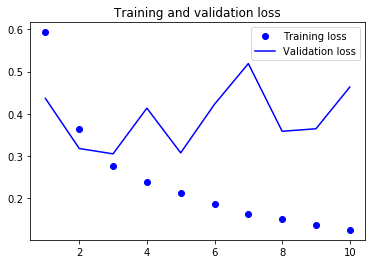

In [28]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Epoch 1/10
200/200 [==============================] - 67s 336ms/step - loss: 0.3133 - val_loss: 0.2781
Epoch 2/10
200/200 [==============================] - 63s 315ms/step - loss: 0.2869 - val_loss: 0.2784
Epoch 3/10
200/200 [==============================] - 65s 326ms/step - loss: 0.2896 - val_loss: 0.2763
Epoch 4/10
200/200 [==============================] - 64s 319ms/step - loss: 0.2812 - val_loss: 0.2791
Epoch 5/10
200/200 [==============================] - 64s 321ms/step - loss: 0.2803 - val_loss: 0.2692
Epoch 6/10
200/200 [==============================] - 64s 319ms/step - loss: 0.2738 - val_loss: 0.2786
Epoch 7/10
200/200 [==============================] - 66s 329ms/step - loss: 0.2725 - val_loss: 0.2719
Epoch 8/10
200/200 [==============================] - 65s 323ms/step - loss: 0.2719 - val_loss: 0.2688
Epoch 9/10
200/200 [==============================] - 88s 440ms/step - loss: 0.2727 - val_loss: 0.2673
Epoch 10/10
200/200 [==============================] - 97s 483ms/step - l

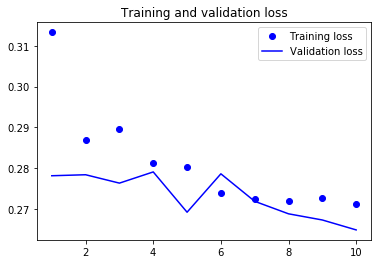

In [26]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=200, epochs=10, validation_data=val_gen, validation_steps=val_steps/batch_size)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()